In [1]:
# Import libraries
from mido import MidiFile, MidiTrack

# Import file stuff
import os

# Import basic
import pandas as pd
import numpy as np

import mido
import matplotlib.pyplot as plt
import random

In [44]:
def get_children(a_dir):
    dirs = []
    files = []
    for name in os.listdir(a_dir):
        if os.path.isdir(os.path.join(a_dir, name)):
            dirs.append(name)
        else:
            files.append(name)
    return [dirs,files]

def create_files_table(top_level, out_file):
    temp_comps = []
    temp_songs = []
    temp_paths = []
    
    composer_names, songs = get_children(top_level)

    for composer in composer_names:
        temp_path = top_level + '/' + composer
        temp, songs = get_children(temp_path)
        for song in songs:
            if song != '.DS_Store':
                temp_comps.append(composer)
                temp_paths.append(temp_path + '/' + song)
                temp_songs.append(song.split(".")[0])

    temp_dict = {'Composers': temp_comps, 'Songs': temp_songs, 'Paths': temp_paths}

    table = pd.DataFrame.from_dict(temp_dict)

    table.to_csv('./' + out_file + '.csv',index=False)
    
    return table

In [45]:
devpath = './Composer_Dataset/NN_midi_files_extended/dev/'
testpath = './Composer_Dataset/NN_midi_files_extended/test/'
trainpath = './Composer_Dataset/NN_midi_files_extended/train/'

dev_table = create_files_table(devpath, 'dev_table')
test_table = create_files_table(testpath, 'test_table')
train_table = create_files_table(trainpath, 'train_table')

## Start Here

In [121]:
# Function to extract the notes played in a MIDI file with timestamps
def extract_notes_with_meta(midi_filepath):
    notes = {}
    midi = mido.MidiFile(midi_filepath)
    max_time = 0
    time_counter = 0
    for track in midi.tracks:
        max_time = max(max_time,time_counter)
        time_counter = 0
        for msg in track:
            time_counter += msg.time
            
            if msg.type == 'note_on':
                if msg.velocity != 0:  # Ensure it's a Note On event
                    notes[msg.note] = notes.get(msg.note, []) + [(msg.velocity, time_counter, 1)]  # 1 represents Note On
            elif msg.type == 'note_off':
                notes[msg.note] = notes.get(msg.note, []) + [(msg.velocity,time_counter, 0)]  # 0 represents Note Off
                
    return notes, max_time


def create_single_sequences(notes, start, tick_count, seq_count): 
    VEL = 0
    TM = 1
    ON = 2
    
    temp_keys = notes.keys()

    seq =  [[0] * 128]* seq_count
    seq = np.array(seq)

    for x in temp_keys:
        temp_note = np.array(notes[x])
        time_store = 0
        for i in range(start, seq_count+start):
            temp_vel = 0
            for t in range(time_store,temp_note[:,TM].size):
                if (temp_note[t,TM]>tick_count*i):
                    break
                else:
                    if temp_note[t,ON] == 1:
                        if temp_note[t,VEL] > temp_vel:
                            temp_vel = temp_note[t,VEL]
                time_store = t
            seq[i-start,x] = temp_vel
    return seq

def sequence_songs(df_songs, tick_count, seq_count):
    labels = []
    sequences = []
    
    for song in df_songs.iterrows():
        song = song[1]
        notes, max_time = extract_notes_with_meta(song['Paths'])
        for i in range(int(max_time/(seq_count*tick_count))):
            sequences.append(create_single_sequences(notes, i*seq_count, tick_count, seq_count))
            labels.append(song['Composers'])
    return labels, sequences

In [72]:
midi_file_path = './Composer_Dataset/NN_midi_files_extended/dev/bach/bach344.mid'
notes, max_time = extract_notes_with_meta(midi_file_path)

new_seq = create_sequences(notes, 100, 200, 100)

In [90]:
new_seq[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0, 127,   0, 127,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 127, 127,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [42]:
max_time

69120

In [46]:
train_table

,Composers,Songs,Paths
0,bach,bach342,./Composer_Dataset/NN_midi_files_extended/trai...
1,bach,bach343,./Composer_Dataset/NN_midi_files_extended/trai...
2,bach,bach345,./Composer_Dataset/NN_midi_files_extended/trai...
3,bach,bach346,./Composer_Dataset/NN_midi_files_extended/trai...
4,bach,bach347,./Composer_Dataset/NN_midi_files_extended/trai...
...,...,...,...
364,schumann,schumann236,./Composer_Dataset/NN_midi_files_extended/trai...
365,schumann,schumann237,./Composer_Dataset/NN_midi_files_extended/trai...
366,schumann,schumann239,./Composer_Dataset/NN_midi_files_extended/trai...
367,schumann,schumann241,./Composer_Dataset/NN_midi_files_extended/trai...


In [122]:
labels, sequences = sequence_songs(train_table, 200, 50)

In [124]:
sequences = np.array(sequences)
sequences[1,48,:]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 127,
         0,   0, 127,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0, 127, 127,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

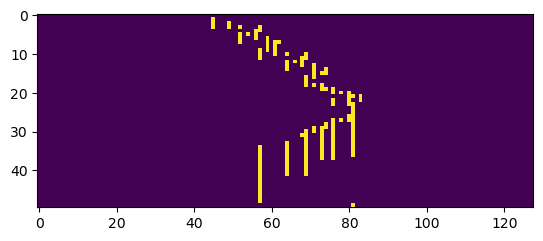

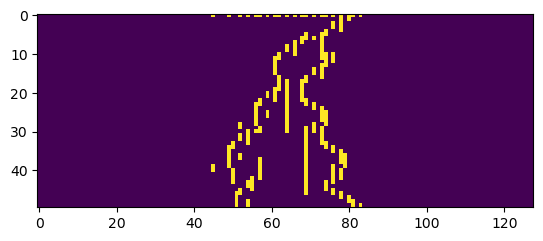

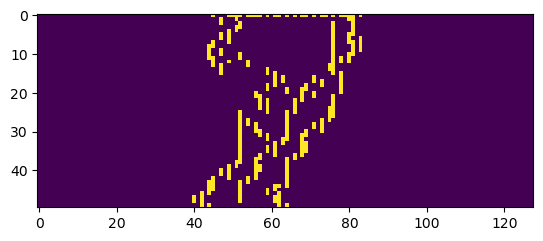

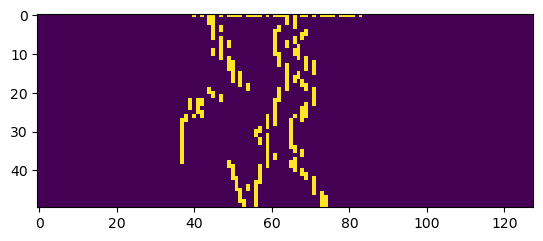

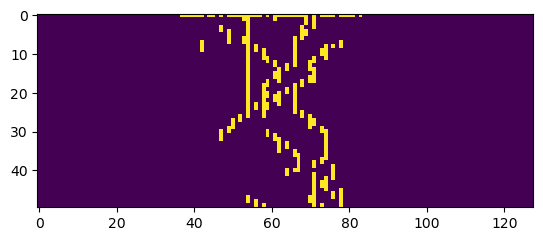

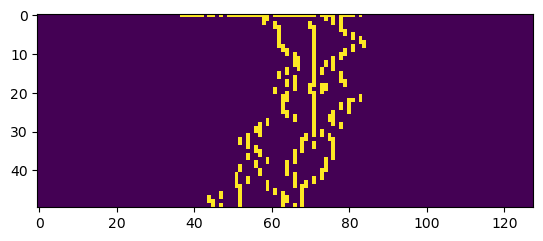

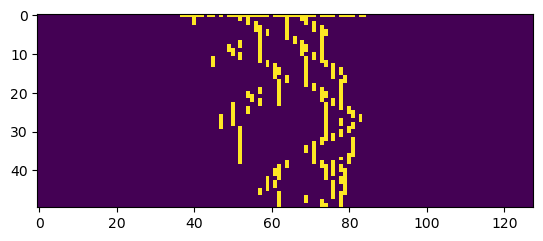

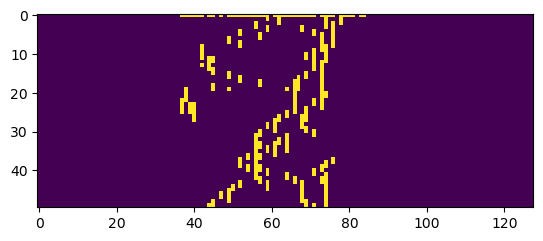

In [129]:
for i in range(8):
    #Show the image with matplotlib
    plt.imshow(sequences[i,:,:])
    # The color will be strange because it's a greyscale image and matlib plot interprets things different than opencv
    plt.show()
